In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
import scipy.stats as stats
from netCDF4 import Dataset
import wrf
import sys
sys.path.append('../../')
from pydicts.obsdict import get_FINO_obs
from mmctools.mmctools.plotting import TaylorDiagram
from mmctools.mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind, w_s, T_d
from mmctools.mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from pydicts.baybreezedict import DetectBayBreeze
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import matplotlib.patches as patches
from string import ascii_lowercase

# Where to save the images:

In [47]:
save_dir = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/img/'

# WRF Data location:

In [4]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'
work_dir   = '/glade/work/hawbecke/ATEC/Chesapeake/SENSITIVITY_STUDY/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


# Load the case dictionary file specifying case names, domains, colors, and markers

In [5]:
from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Get Obs

In [6]:
read_in_obs = True

In [7]:
if read_in_obs:
    obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
    awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
    asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
    apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

In [8]:
near_shore_stations  = []
inland_station_names = []
for stn in awos_ds.get_index('station'):
    if awos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if awos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in asos_ds.get_index('station'):
    if asos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if asos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in apg_ds.get_index('station'):
    near_shore_stations.append(stn)

near_shore_stations = np.unique(near_shore_stations)
inland_station_names = np.unique(inland_station_names)

# Get WRF towers

### To get towers interpolated to obs levels:

In [9]:
ref_stn = 'IAD'

In [10]:
wrf_twrs = {}
for cc,case in enumerate(cases):
    dom = case_dom[cc]
    case_str = '{}_{}'.format(case,'d0{}'.format(dom))
    if dom == 3:
        dt = 9.0
    elif dom == 4:
        dt = 3.0
    else:
        print('Add logic for domain {}'.format(dom))
    print('Starting {} d0{}: time step = {}'.format(case_str,dom,dt))
    

    case_dir = '{}{}/'.format(work_dir,case)
    twr_path = '{}{}_d0{}_towers.nc'.format(case_dir,case,dom)    
    if path.exists(twr_path):
        print('loading in full dataset!')
        wrf_twrs[case_str] = xr.open_dataset(twr_path)
    else:
        wrf_twrs[case_str] = tsout_seriesReader(case_dir,restarts,wrf_start,'d0{}'.format(dom),structure='unordered',
                                            select_tower=np.append(near_shore_stations,ref_stn),time_step=dt,
                                            #select_tower=near_shore_stations[:2],time_step=dt,
                                            heights=[10.0],height_var='ph')
        wrf_twrs[case_str]['temp'] = theta_to_T(wrf_twrs[case_str].theta,wrf_twrs[case_str].pr/100.0)-273.15
        wrf_twrs[case_str]['wspd10'],wrf_twrs[case_str]['wdir10'] = calc_wind(wrf_twrs[case_str],u='u10',v='v10')
        wrf_twrs[case_str]['t2'] += -273.15 
        wrf_twrs[case_str].to_netcdf(twr_path)

Starting GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_NOSK_4DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03 d0

In [11]:
t_s = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(3,'s') # Account for spinup
t_e = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[-1]

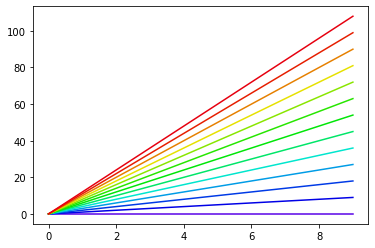

In [12]:
stn_colors = {}
for ss,stn in enumerate(near_shore_stations):
    line_cols = plt.cm.gist_rainbow_r(np.linspace(0.15,1.0,len(near_shore_stations)))[ss]
    darken = 0.1
    #line_cols = plt.cm.Set1_r(np.linspace(0.4,1.0,len(near_shore_stations)))[ss]
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(near_shore_stations):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn])
    


In [13]:
vars_to_compare = {'wspd':'wspd10',
                   'wdir':'wdir10',
                   'temp':'t2'}

# Resample obs and model data:

In [14]:
# Many stations are missing data - these are the good ones:
near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']

In [15]:
for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        obs_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        obs_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    obs_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        obs_ds = apg_ds.sel(station='PAA')
        obs_ds.station.data = 'APG'

    obs_res = obs_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in obs_res.data_vars:
        if dd not in vars_to_compare:
            obs_res = obs_res.drop_vars(dd)
    obs_res = obs_res.resample(datetime='5min').nearest(tolerance='5min')
    if ss == 0:
        obs_res_full = obs_res
    else:
        obs_res_full = xr.concat([obs_res_full,obs_res],dim='station')


In [16]:
def resample_model_output(stn_ds,obs_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(obs_ds) == dict:
                obs = obs_ds[stn]
            elif type(obs_ds) == xr.core.dataset.Dataset:
                obs = obs_ds.sel(station=stn)
            else:
                'Need to figure out data type of obs_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [17]:
wrf_twrs_res = {}
for cc,case in enumerate(wrf_twrs):        
    wrf_twrs_res[case] = resample_model_output(wrf_twrs[case].copy().sel(datetime=slice(t_s,t_e)).resample(
                                               datetime='5min').nearest(tolerance='5min'),
                                               obs_res_full,var_dict=vars_to_compare,
                                               select_stations=near_shore_stations)

# Taylor Diagrams

In [18]:
remove_mean = False


remove_night = True
night_hour_s = 22
night_hour_e = 12

remove_low_wspds = True
wspd_cutoff = 1.4

only_observed_bb_days = False

save_figs   = True


TD_stns = list(near_shore_stations.copy())
# APG and MTN do not have enough data for the Taylor Diagrams
#TD_stns.remove('APG')
#TD_stns.remove('MTN')

markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']


'''
#Orig (mar 2020)
bb_observed_dates = {'StaufferThompson2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-09' : ['MTN', 'NAK'],
                                                '2019-07-10' : ['NUI'],
                                                '2019-07-11' : ['NAK'],
                                                '2019-07-15' : ['MTN', 'NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-17' : ['NAK'],
                                                '2019-07-19' : ['MTN'],
                                                '2019-07-20' : ['MTN'],
                                                '2019-07-24' : ['NUI'],
                                                '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                                '2019-07-27' : ['MTN', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                             'Stauffer2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-07' : ['NHK'],
                                                '2019-07-09' : ['NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NAK', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['NAK', 'NHK'],
                                                '2019-07-30' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                               'Sikora2010': {  '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NHK'],
                                                '2019-07-28' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']}
                    }

# Old (jul 30, 2020)
bb_observed_dates = {
                    'StaufferThompson2015' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-09' : ['NAK', 'MTN'],
                                              '2019-07-10' : ['NHK', 'NUI'],
                                              '2019-07-15' : ['NAK', 'MTN'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-17' : ['NAK'],
                                              '2019-07-19' : ['NHK', 'MTN', 'NAK'],
                                              '2019-07-20' : ['MTN'],
                                              '2019-07-24' : ['NUI'],
                                              '2019-07-25' : ['NAK', 'NHK'],
                                              '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                              '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-28' : ['NAK', 'NHK'],
                                              '2019-07-29' : ['NAK', 'NHK', 'MTN'],
                                              '2019-07-30' : ['NAK', 'NUI', 'APG', 'NHK'],
                                              '2019-07-31' : ['NAK', 'NHK'],
                                             },
                            'Stauffer2015' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-05' : ['BWI'],
                                              '2019-07-09' : ['NAK', 'MTN'],
                                              '2019-07-10' : ['NHK', 'NUI'],
                                              '2019-07-15' : ['NAK', 'MTN'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-17' : ['NAK'],
                                              '2019-07-19' : ['NHK', 'MTN', 'NAK'],
                                              '2019-07-20' : ['MTN'],
                                              '2019-07-24' : ['NUI'],
                                              '2019-07-25' : ['NAK', 'NHK'],
                                              '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                              '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-28' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-29' : ['NAK', 'NHK', 'MTN'],
                                              '2019-07-30' : ['NAK', 'NUI', 'APG', 'NHK'],
                                              '2019-07-31' : ['NHK', 'NAK'],
                                             },
                              'Sikora2010' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-10' : ['NHK'],
                                              '2019-07-15' : ['NAK'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-19' : ['NHK'],
                                              '2019-07-25' : ['NAK'],
                                              '2019-07-27' : ['NAK', 'NHK'],
                                              '2019-07-28' : ['NAK'],
                                              '2019-07-29' : ['NAK', 'NHK'],
                                              '2019-07-30' : ['NAK', 'NHK'],
                                              '2019-07-31' : ['NHK'],
                                             },
                    }

bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-24' : ['NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Stauffer2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Sikora2010' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     }


'''
# After adjusting the algorithms to match closer to the papers and not including days when SWT was in area
bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-02' : ['MTN', 'APG'],
                                               '2019-07-04' : ['NHK', 'NUI'],
                                               '2019-07-06' : ['MTN', 'APG'],
                                               '2019-07-09' : ['NAK', 'MTN'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['NAK'],
                                               '2019-07-16' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-17' : ['MTN', 'NAK'],
                                               '2019-07-19' : ['NAK', 'MTN', 'NHK', 'APG'],
                                               '2019-07-22' : ['MTN'],
                                               '2019-07-24' : ['NUI', 'NUI', 'NAK'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-26' : ['MTN', 'BWI'],
                                               '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                               '2019-07-28' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                               '2019-07-30' : ['MTN', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NHK'],
                                              },
                     'Stauffer2015' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-04' : ['NHK'],
                                               '2019-07-10' : ['NHK'],
                                               '2019-07-15' : ['NAK'],
                                               '2019-07-16' : ['NAK'],
                                               '2019-07-17' : ['NAK'],
                                               '2019-07-19' : ['NHK'],
                                               '2019-07-27' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-28' : ['NAK'],
                                               '2019-07-29' : ['NAK', 'NHK'],
                                               '2019-07-30' : ['NAK', 'NHK'],
                                               '2019-07-31' : ['NHK'],
                                              },
                     'Sikora2010' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-05' : ['BWI'],
                                               '2019-07-10' : ['NUI'],
                                               '2019-07-16' : ['NAK'],
                                               '2019-07-24' : ['NUI', 'NAK'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NHK'],
                                               '2019-07-28' : ['NAK', 'NHK'],
                                              },
                     }

bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))

#bay_breeze_days_from_obs = ['2019-07-09','2019-07-10','2019-07-11','2019-07-15',
#                            '2019-07-16','2019-07-17','2019-07-19','2019-07-20',
#                            '2019-07-24','2019-07-26','2019-07-27','2019-07-28',
#                            '2019-07-29','2019-07-31']

TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

TD_start = t_s
TD_end   = t_e

TD_vars = {'wspd':'wspd10','temp':'t2'}

## Make adjustments to the data as prescribed:

In [22]:
TD_obs_full = {}
plt_start_date = pd.to_datetime(obs_ds.datetime.values[0])
plt_end_date = pd.to_datetime(obs_ds.datetime.values[-1])
for ss,stn in enumerate(TD_stns):
    temp_obs_ds = obs_res_full.sel(station=stn).copy()
    for var in TD_vars:
        obs_var = var
        temp_obs_ds.drop_vars(obs_var)
        obs = obs_res_full.sel(station=stn)[obs_var].copy()

        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdir10A'

        if remove_low_wspds and (obs_var == 'wspd' or obs_var == 'wdir'): 
            print(var)
            #obs = obs_ds[['wspd','wdir']].dropna(how='any',dim='datetime')
            obs.data[np.where(obs_res_full.sel(station=stn).wspd.data < wspd_cutoff)] = np.nan
            obs.data[np.where(obs_res_full.sel(station=stn).wspd.data < wspd_cutoff)] = np.nan
            
        if remove_night:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_obs_ds[obs_var] = obs
        
    TD_obs_full[stn] = temp_obs_ds
    

TD_wrf_twrs = {}
for cc,case in enumerate(cases):

    temp_twr_ds = wrf_twrs_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))].copy()

    for vv,var in enumerate(TD_vars):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)

        temp_var = wrf_twrs_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][sim_var].copy()
        
        for ss,stn in enumerate(TD_stns):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdir10A'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = temp_twr_ds


wspd


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


wspd
wspd
wspd
wspd
wspd


In [23]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

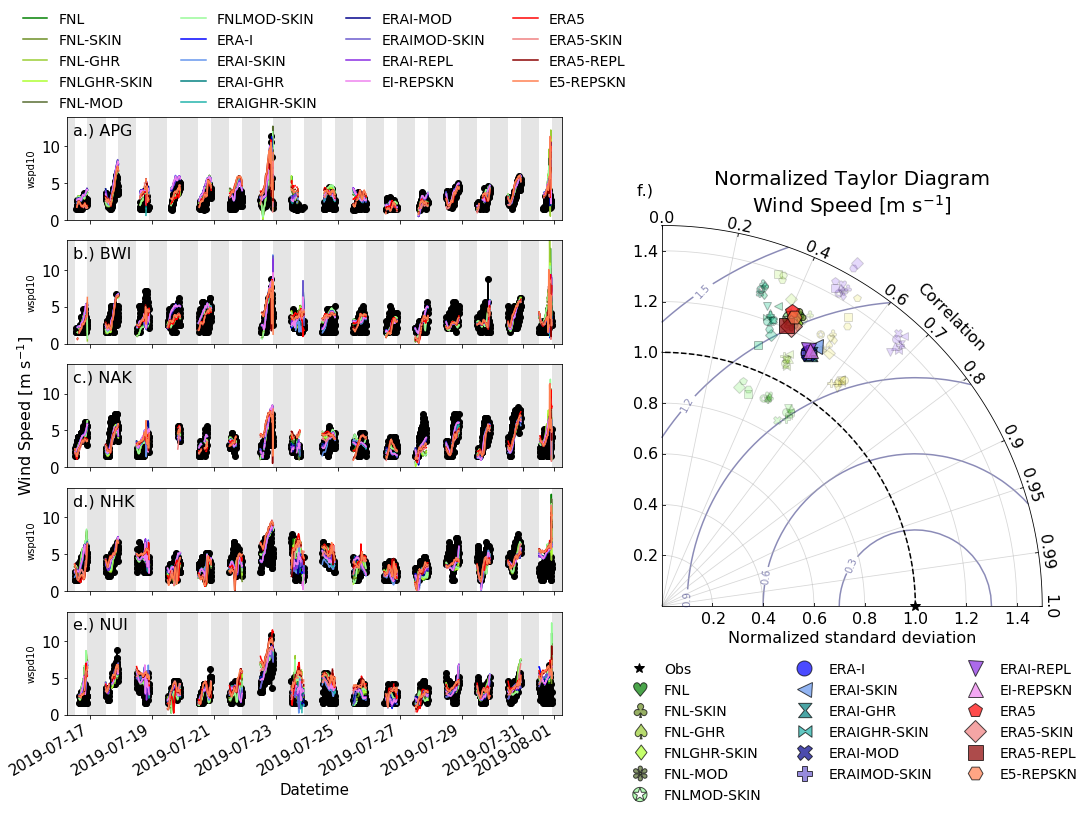

In [24]:
ymin,ymax = 0,14
ylabel = 'Wind Speed [m s$^{-1}$]'
sim_var = 'wspd10'
obs_var = 'wspd'
var_str = 'Wind Speed [m s$^{-1}$]'

fig = plt.figure(figsize=(16,11.0))
plt.subplots_adjust(wspace=0.3)

TD_stns_plt = TD_stns.copy()
TD_stns_plt.remove('MTN')
gs1 = gridspec.GridSpec(len(TD_stns_plt), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(TD_stns_plt):
    ax1 = plt.subplot(gs1[ss])

    obs = TD_obs_full[stn][obs_var] 

    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]


        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim #.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    if ss == 2: ax1.set_ylabel(ylabel,size=16)
    if ss == 4:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    txt_y = txt_y = ymin + 0.8*(ymax-ymin)
    #if (stn == 'APG') or (stn == 'BWI'): txt_y = ymin + 0.80*(ymax-ymin)
    ax1.text(obs.datetime.data[60],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(-0.1,1.01),fontsize=14,handlelength=1.75)


        
extend = False
TD_max_r = 1.5

dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}

for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):
        if stn != 'MTN':

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.51),ncol=3)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.03,1.62,'f.)',size=16,ha='right')
figname = '{}Inland_wspdTD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

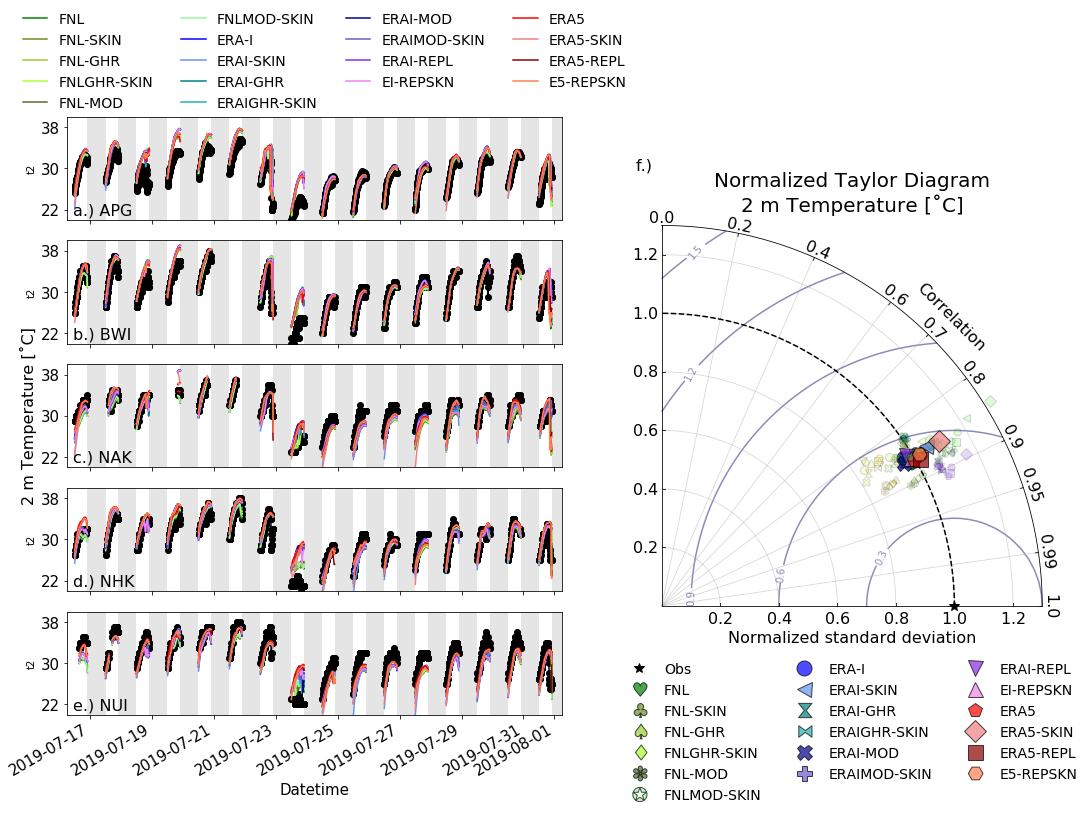

In [25]:
ymin,ymax = 20,40
ylabel = '2 m Temperature [˚C]'
sim_var = 't2'
obs_var = 'temp'
var_str = '2 m Temperature'

fig = plt.figure(figsize=(16,11.0))
plt.subplots_adjust(wspace=0.3)

TD_stns_plt = TD_stns.copy()
TD_stns_plt.remove('MTN')
gs1 = gridspec.GridSpec(len(TD_stns_plt), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(TD_stns_plt):
    ax1 = plt.subplot(gs1[ss])

    obs = TD_obs_full[stn][obs_var] 

    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]


        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim #.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    if ss == 2: ax1.set_ylabel(ylabel,size=16)
    if ss == 4:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date, end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    txt_y = txt_y = ymin + 0.02*(ymax-ymin)
    #if (stn == 'APG') or (stn == 'BWI'): txt_y = ymin + 0.80*(ymax-ymin)
    ax1.text(obs.datetime.data[60],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_yticks([22,30,38])
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(-0.1,1.01),fontsize=14,handlelength=1.75)


        
extend = False
TD_max_r = 1.3

dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}

for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):
        if stn != 'MTN':

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        #dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
        #       marker=case_plt_dict['marker'], ms=15, ls='',
        #       mfc=case_plt_dict['color'], mec='k', # Colors
        #       label=case_plt_dict['name'],
        #       zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.51),ncol=3)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.03,1.49,'f.)',size=16,ha='right')
figname = '{}Inland_tempTD'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# Detect Bay Breeze

In [26]:
# Start time:     0900 Local (1300 UTC) 
start_time = pd.to_timedelta(13,unit='h')
# End time:       1600 Local (2000 UTC)
end_time   = pd.to_timedelta(20,unit='h')

detection_methods = ['StaufferThompson2015','Stauffer2015','Sikora2010']

In [27]:
bb_detection_dict_fname = '{}wrf_bay_breeze_detections_final_RealSampleRate.txt'.format(work_dir)
if path.exists(bb_detection_dict_fname):
    print('loading in full dataframe!')
    bb_case_df = pd.read_csv(bb_detection_dict_fname,delimiter='\t',names=
                             ['case','method','station','detection_dates'])
else:
    bb_case_dict = {}
    for cc,case in enumerate(cases_of_interest):
        bb_case_dict['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = {}
        for dm,detection_method in enumerate(detection_methods):
            if detection_method == 'StaufferThompson2015':
                sample_rate = '60min'
            elif detection_method == 'Stauffer2015':
                sample_rate = '5min'
            elif detection_method == 'Sikora2010':
                sample_rate = '60min'  
            bb_count = 0
            print(detection_method)
            bb_case_dict['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][detection_method] = {}
            for dd,day in enumerate(pd.date_range(start=t_s - pd.to_timedelta(t_s.hour,'h') - \
                                                  pd.to_timedelta(t_s.second,'s'), end=t_e)):
                twr_dat_f = wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))]
                if dd == 0:
                    print('Initializing bb_stn_dict')
                    bb_stn_dict = {}
                for stn in near_shore_stations:
                    if dd == 0: 
                        bb_stn_dict[stn] = []
                    #fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True)

                    if stn in asos_ds.get_index('station'):
                        obs_ds = asos_ds.sel(station=stn).sel(datetime=slice(t_s,t_e))
                    elif stn in awos_ds.get_index('station'):
                        obs_ds = awos_ds.sel(station=stn).sel(datetime=slice(t_s,t_e))
                    else:
                        print('no obs for this station')
                    #obs_ds = obs_res_full.sel(station=stn)
                    twr_dat = twr_dat_f.sel(station=stn)
                    twr_dat['onshore_max'] = obs_ds.onshore_max
                    twr_dat['onshore_min'] = obs_ds.onshore_min
                    if stn == 'APG':
                        obs_ds = apg_ds.sel(station='PAA')
                        obs_ds.station.data = 'APG'
                        
                    if detection_method == 'Stauffer2015':
                        twr_dat['dwpt'] = T_d(twr_dat.t2 + 273.15,
                                              100.0*(twr_dat.q2/w_s(twr_dat.t2 + 273.15, twr_dat.psfc/100.0)))


                    
                    station         = twr_dat.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                 str(pd.to_datetime(day)+end_time))).isel(nz=0)
                    inland_stations = wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))].sel(station=ref_stn,
                                                 datetime=slice(str(pd.to_datetime(day)+start_time),
                                                 str(pd.to_datetime(day)+end_time))).isel(nz=0)


                    bay_breeze      = DetectBayBreeze(station,inland=inland_stations,verbose=False,resample=True,
                                                      sample_rate=sample_rate,show_plot=False,method=detection_method)
                    if bay_breeze.validated:
                        bb_count += 1
                        bb_stn_dict[stn] = np.concatenate([bb_stn_dict[stn],[str(day)]])

            for stn in near_shore_stations[0:]:
                bb_case_dict['{}_{}'.format(case,'d0{}'.format(
                                        case_dom[cc]))][detection_method][stn] = bb_stn_dict[stn]

        
    new_f = open(bb_detection_dict_fname,'w')
    for case in bb_case_dict:
        for det_meth in bb_case_dict[case]:
            for stn in bb_case_dict[case][det_meth]:
                detections = bb_case_dict[case][det_meth][stn]
                detections = ','.join(detections)
                if detections == '':
                    detections = 'None'
                else:
                    detections = detections.replace(' ','_')
                new_f.write('{}\t{}\t{}\t{}\n'.format(case, det_meth,stn,detections))
    new_f.close()
    bb_case_df = pd.read_csv(bb_detection_dict_fname,delimiter='\t',names=['case','method','station','detection_dates'])


loading in full dataframe!


# Make LaTeX Table for the cases:

### Need to split the table into 2 or more pieces...

In [28]:
stn_str_dict = {'APG':'A',
                'BWI':'B',
                'NAK':'K',
                'NHK':'H',
                'NUI':'N',
                'MTN':'M'}

mth_str_dict = {'StaufferThompson2015' : 'ST',
                        'Stauffer2015' : 'S',
                          'Sikora2010' : 'K'}

cases_table_full = [
                     ['ERAI_YSU_CHRN_OST_NOSK_4DOM'],
    
                     ['GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                      'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
                      'GFSR_YSU_CHRN_GHR_NOSK_3DOM'],
    
                     ['GFSR_YSU_CHRN_GHR_SKNT_3DOM',
                      'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                      'GFSR_YSU_CHRN_MOD_SKNT_3DOM',],

                     ['ERAI_YSU_CHRN_OST_NOSK_4DOM',
                      'ERAI_YSU_CHRN_OST_SKNT_3DOM',
                      'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                      'ERAI_YSU_CHRN_GHR_SKNT_3DOM'],
    
                     ['ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                      'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
                      'ERAI_YSU_CHRN_OST_OVER_3DOM',
                      'ERAI_YSU_CHRN_OST_OVSK_3DOM'],

                     ['ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                      'ERA5_YSU_CHRN_ER5_SKNT_3DOM'],
                     ['ERA5_YSU_CHRN_ER5_OVER_3DOM',
                      'ERA5_YSU_CHRN_ER5_OVSK_3DOM']
                    ]


# LaTeX color definitions

In [29]:
for stn_c in stn_colors:
    print(r'\definecolor{'+stn_c+'}{rgb}{' + '{},{},{}'.format(stn_colors[stn_c][0],stn_colors[stn_c][1],stn_colors[stn_c][2]) + '}')

\definecolor{APG}{rgb}{0.3401108269394716,0.0,0.9}
\definecolor{BAR}{rgb}{0.0,0.0,0.9}
\definecolor{BBB}{rgb}{0.0,0.22715260017050262,0.9}
\definecolor{BWI}{rgb}{0.0,0.6107843137254901,0.9}
\definecolor{MFD}{rgb}{0.0,0.9,0.8065991988193129}
\definecolor{MIR}{rgb}{0.0,0.9,0.4060088551549653}
\definecolor{MTN}{rgb}{0.0,0.9,0.026502213788741263}
\definecolor{NAK}{rgb}{0.15437201907790135,0.9,0.0}
\definecolor{NHK}{rgb}{0.5359300476947535,0.9,0.0}
\definecolor{NUI}{rgb}{0.9,0.8825119236883945,0.0}
\definecolor{OBO}{rgb}{0.9,0.5009538950715423,0.0}
\definecolor{PAA}{rgb}{0.9,0.11939586645468989,0.0}
\definecolor{SPI}{rgb}{0.9,0.0,0.06}


# Confusion matrix dictionary:

In [30]:
confusion_matrix_dict = {}
for case in np.unique([item for sublist in cases_table_full for item in sublist]):
    confusion_matrix_dict['{}_d03'.format(case)] = {}
    for meth in detection_methods:
        confusion_matrix_dict['{}_d03'.format(case)][meth] = {}

n_bb_stn = 6 # 6 if you do APG

# BIG TABLE!

In [31]:
confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
stn_cnt = 0
for tt,cases_table in enumerate(cases_table_full):
    for dd,day in enumerate(pd.date_range(start=t_s, end=t_e)):
#    for dd,day in enumerate(pd.date_range(start=t_s, end=pd.to_datetime('2019-07-18'))):
        count = 0
        date_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
        if date_str in bay_breeze_days_from_obs:
            day_str = r'\textbf{' + date_str + r'}'
            day_str = date_str
        else:
            day_str = date_str
        day_line = '{} & '.format(day_str)
        init_line = True
        for row in bb_case_df.T.iteritems(): 

            case   = row[1][0]
            method = row[1][1]
            stn    = row[1][2]
            dates  = row[1][3].replace('_',' ')
            stn_str_f = stn_str_dict[stn]
            bb_obs = False
            bb_sim = False
            if '_'.join(case.split('_')[:-1]) in cases_table and case.split('_')[-1] == 'd03':
                stn_cnt += 1
                if init_line:
                    prev_method = method
                    prev_case   = case

                    header_1    = ' & \multicolumn{3}{c||}{' + case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                    header_2    = r' \textbf{Date} & \textbf{' + '{}'.format(mth_str_dict[method] + r'}')
                    hd2_fmt     = '|r|c|'
                    init_line = False
                    #print(date_str,bb_observed_dates[method][date_str])

                if method != prev_method:
                    day_line = day_line[:-1] + ' & '
                    if dd == 0:
                        if case != prev_case:
                            header_1 = header_1 + '\multicolumn{3}{c||}{' + \
                                       case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                            header_2 = header_2 + r' & \textbf{' + '{}'.format(mth_str_dict[method] + r'}')
                            hd2_fmt = hd2_fmt + '|c|'
                        else:
                            header_2 = header_2 + r' & \textbf{' + '{}'.format(mth_str_dict[method] + r'}')
                            #header_2 = header_2 + ' & {}'.format(mth_str_dict[method])
                            hd2_fmt = hd2_fmt + 'c|'

                if case != prev_case:
                    day_line = day_line[:-1] + ' '
                    
                if date_str in dates:
                    #print('{} simulated a bb on this date'.format(stn))
                    bb_sim = True
                    stn_str_f = r'\textcolor{' + stn + '}{'+ stn_str_f + r'}'
                else:
                    #print('{} did not simulate a bb on this date'.format(stn))
                    stn_str_f = stn_str_f                    
                if date_str in bb_observed_dates[method]:

                    bay_breeze_stations_for_this_date = bb_observed_dates[method][date_str]

                    if stn in bay_breeze_stations_for_this_date:
                        #print('{} observed a bb on this date'.format(stn))
                        bb_obs = True
                        stn_str_f = r'\textbf{' + stn_str_f + r'}'
                    else:
                        stn_str_f = stn_str_f                    
                    #    print('{} did not observe a bb on this date'.format(stn))
                else:
                    stn_str_f = stn_str_f

                if bb_obs and bb_sim:
                    stn_str_f = r'\underline{' + stn_str_f + r'}'
                    
                if stn == 'MTN' and method != 'StaufferThompson2015': # MTN doesn't have temp / dwpt data... don't count.
                    stn_str_f = r'\xcancel{' + stn_str_f + r'}'
                    
                    
                day_line = day_line + '{} '.format(stn_str_f)
                
                if not (stn == 'MTN' and method != 'StaufferThompson2015'):
                    if bb_sim and bb_obs:
                        #print('True Positive')
                        confusion_matrix['TP'] += 1
                    if bb_sim and not bb_obs:
                        #print('False Positive')
                        confusion_matrix['FP'] += 1
                    if not bb_sim and not bb_obs:
                        #print('True Negative')
                        confusion_matrix['TN'] += 1
                    if not bb_sim and bb_obs:
                        #print('False Negative')
                        confusion_matrix['FN'] += 1
                    
                if stn_cnt == n_bb_stn:
                    if dd == 0:
                        confusion_matrix_dict[case][method] = confusion_matrix
                    else:
                        for val in confusion_matrix_dict[case][method]:
                            #print(val)
                            confusion_matrix_dict[case][method][val] += confusion_matrix[val]
                    confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
                    stn_cnt = 0
                

                prev_method = method
                prev_case   = case        
                #print()
                count+=1
                #if count > 9:
                #    print(day_line)
                #    wefwef

        
        if dd == 0:
            header_1 = header_1[:-1] + ' \\\ \n'
            header_2 = header_2 + ' \\\ \n'


            if tt == 0:
                print(r'\begin{landscape}')
                print(r'\thispagestyle{empty}')
                print(r'    \noindent')
                print(r'\renewcommand{\arraystretch}{0.65}')
                print(r'\footnotesize')
            print(r'\begin{tabular}{ '+hd2_fmt+' }')
            print(r'\hline')
            print(header_1)
            print(r'\hline')
            print(header_2)
            print(r'\specialrule{.1em}{.05em}{.05em}' + '\n')
            #print(r'\hline')
        day_line = day_line[:-1] + ' \\\ \n'

        print(day_line)
        print(r'\hline')
    print(r'\end{tabular}')

    
    print()
    print()
    print()
    
print(r'\renewcommand{\arraystretch}{1.0}')
print(r'\end{landscape}')    
   
    
    
    

\begin{landscape}
\thispagestyle{empty}
    \noindent
\renewcommand{\arraystretch}{0.65}
\footnotesize
\begin{tabular}{ |r|c|c|c| }
\hline
 & \multicolumn{3}{c||}{ERA-I}  \\ 

\hline
 \textbf{Date} & \textbf{ST} & \textbf{S} & \textbf{K} \\ 

\specialrule{.1em}{.05em}{.05em}

2019-07-16 & A B \underline{\textbf{\textcolor{MTN}{M}}} \underline{\textbf{\textcolor{NAK}{K}}} \textbf{H} N & A B \xcancel{M} \textbf{K} H N & A B \xcancel{\textcolor{MTN}{M}} \underline{\textbf{\textcolor{NAK}{K}}} H N \\ 

\hline
2019-07-17 & \textcolor{APG}{A} B \underline{\textbf{\textcolor{MTN}{M}}} \textbf{K} H N & A B \xcancel{M} \textbf{K} H N & \textcolor{APG}{A} B \xcancel{\textcolor{MTN}{M}} K H N \\ 

\hline
2019-07-18 & \textcolor{APG}{A} B \textcolor{MTN}{M} K H N & A B \xcancel{M} K H N & A B \xcancel{M} K H N \\ 

\hline
2019-07-19 & \textbf{A} B \textbf{M} \textbf{K} \textbf{H} N & A B \xcancel{M} K \textbf{H} N & A B \xcancel{M} K H N \\ 

\hline
2019-07-20 & A B M K H N & A B \xcancel{M} K H N

In [32]:
from IPython.core.display import HTML,display

color="255,127,80"  # coral

def print_color(text,c):
    source = "<h1 style='color: rgb({1})'> {0} </h1>".format(text,c)
    return HTML(source)

for ss,stn in enumerate(['APG','BWI','MTN','NAK','NHK','NUI']):
    color_str = '{},{},{}'.format(stn_colors[stn][0]*256,stn_colors[stn][1]*256,stn_colors[stn][2]*256)
    display(print_color('{} = {}'.format(stn_str_dict[stn],stn),color_str))


In [33]:
for case in confusion_matrix_dict:
    for meth in confusion_matrix_dict[case]:
        print(case,meth,sum(confusion_matrix_dict[case][meth].values()))

ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 Stauffer2015 80
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 Sikora2010 80
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 Stauffer2015 80
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 Sikora2010 80
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 Stauffer2015 80
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 Sikora2010 80
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 Stauffer2015 80
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 Sikora2010 80
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 Stauffer2015 80
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 Sikora2010 80
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 Stauffer2015 80
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 Sikora2010 80
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 Stauffer2015

In [34]:
detection_method_names_dict = {'StaufferThompson2015':'Stauffer and Thompson (2015)',
                                       'Stauffer2015':'Stauffer et al. (2015)',
                                         'Sikora2010':'Sikora et al. (2010)'}

In [35]:
print(r'\begin{table}')
#print(r'\renewcommand{\arraystretch}{0.65}')
print(r'\begin{center}')
print(r'\caption{\label{table:summary_table}[Insert caption.]}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
#print(r'\begin{tabular}{ |c||c|c|c|c||c|c|c|c||c|c|c|c|}')
tabular_line = r'\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}' + \
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|}'

print(tabular_line)
print(r'\hline')
method_line_fmt = r' & '
for mm,method in enumerate(detection_methods):
    if mm < 2:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{'
    else:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}|}{\textbf{'
        
    method_line_fmt += method_preamble + detection_method_names_dict[method] + r'}} & '
method_line_fmt = method_line_fmt[:-2] + r'\\'
print(method_line_fmt)
print(r'\hline')
    
    
print(r'\textbf{Case} ' + r'& {\small\textbf{TP}} & {\small\textbf{TN}} & {\small\textbf{FN}} & {\small\textbf{FP}} '*3 + r' \\ ')
print(r'\specialrule{.1em}{.05em}{.05em}')

for cc,case in enumerate(cases_of_interest):
    if cc == 0: 
        case_0 = case[:4]
    else:
        if case[:4] == case_0:
            print(r'\hline')
        else:
            case_0 = case[:4]
            print(r'\specialrule{.1em}{.05em}{.05em}')        
    case_n = case_dict[case]['d03']['name']
    case_str = case_n + r' &'
    #print(case_str)
    c_matrix_str = case_n + ' &'
    for mm,method in enumerate(detection_methods):
        c_matric_dict = confusion_matrix_dict['{}_d03'.format(case)][method]
        c_matrix_str += (' {} & {} & {} & {} &'.format(
                    c_matric_dict['TP'],c_matric_dict['TN'],c_matric_dict['FN'],c_matric_dict['FP']))
    c_matrix_str = c_matrix_str[:-1] + r'\\'
    #c_matrix_str = ' {0} & {1} & {2} & {3} \\\ '.format(TP_count,TN_count,FP_count,FN_count)
    

    print(c_matrix_str)

print(r'\hline')

print(r'\end{tabular}')

print(r'\egroup')
print(r'\end{center}')

print(r'\end{table}')


\begin{table}
\begin{center}
\caption{\label{table:summary_table}[Insert caption.]}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|}
\hline
 & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer and Thompson (2015)}} & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer et al. (2015)}} & \multicolumn{4}{>{\b

# Summarize big table with "did this method predict ANY station to have a bb and did ANY observed station record a bb"

In [36]:
bb_on_this_day_dict = {}
for cc,case in enumerate(cases):
    bb_on_this_day_dict[case] = {}
    for dd,day in enumerate(pd.date_range(start=t_s, end=t_e)):
        obs_bb_today = False
        sim_bb_today = False
    #    for dd,day in enumerate(pd.date_range(start=t_s, end=pd.to_datetime('2019-07-18'))):
        count = 0
        date_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
        bb_on_this_day_dict[case][date_str] = {}
        init_line = True
        
        # Find days with observed bay breeze:
        obs_methods_bb_today = {}
        for method in detection_methods:
            obs_methods_bb_today[method] = False
        for method in detection_methods:
            if date_str in list(bb_observed_dates[method].keys()):
                obs_methods_bb_today[method] = True
                obs_bb_today = True

            
        # Find days with simulated bay breeze:
        sim_methods_bb_today = {}
        for method in detection_methods:
            sim_methods_bb_today[method] = False
            
        for row in bb_case_df.T.iteritems():
            bbcase   = row[1][0]
            bbmethod = row[1][1]
            bbstn    = row[1][2]
            bbdates  = row[1][3].replace('_',' ')
            if case in bbcase:
                if date_str in bbdates:
                    if not (bbstn == 'MTN' and bbmethod != 'StaufferThompson2015'):
                        sim_methods_bb_today[bbmethod] = True
                        #print(date_str,bbstn,bbmethod,'True')
        
                    
        # Assign to dictionary
        bb_on_this_day_dict[case][date_str]['observed'] = obs_methods_bb_today
        bb_on_this_day_dict[case][date_str]['simulated'] = sim_methods_bb_today
        

In [37]:
bb_on_this_day_confusion_matrix = {}
for cc,case in enumerate(cases):
    bb_on_this_day_confusion_matrix[case] = {}
    for method in detection_methods:
        bb_on_this_day_confusion_matrix[case][method] = {'TP':0,'TN':0,'FN':0,'FP':0}
        
    bb_on_this_day = bb_on_this_day_dict[case]
    for dd,day in enumerate(list(bb_on_this_day.keys())):
        #print(day)
        obs_bb_today = bb_on_this_day_dict[case][day]['observed']
        sim_bb_today = bb_on_this_day_dict[case][day]['simulated']
        for method in detection_methods:
            obs_bb_today_method = obs_bb_today[method]
            sim_bb_today_method = sim_bb_today[method]
            #print('{}: observed = {}, simulated = {}'.format(method,obs_bb_today_method,sim_bb_today_method))
            if obs_bb_today_method and sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['TP'] += 1
            if obs_bb_today_method and not sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['FN'] += 1
            if not obs_bb_today_method and not sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['TN'] += 1
            if not obs_bb_today_method and sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['FP'] += 1
       

In [38]:
print(r'\begin{table}')
#print(r'\renewcommand{\arraystretch}{0.65}')
print(r'\begin{center}')
print(r'\caption{\label{table:summary_table}[Insert caption.]}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
#print(r'\begin{tabular}{ |c||c|c|c|c||c|c|c|c||c|c|c|c|}')
tabular_line = r'\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}' + \
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|}'

print(tabular_line)
print(r'\hline')
method_line_fmt = r' & '
for mm,method in enumerate(detection_methods):
    if mm < 2:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{'
    else:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}|}{\textbf{'
        
    method_line_fmt += method_preamble + detection_method_names_dict[method] + r'}} & '
method_line_fmt = method_line_fmt[:-2] + r'\\'
print(method_line_fmt)
print(r'\hline')
    
    
print(r'\textbf{Case} ' + r'& {\small\textbf{TP}} & {\small\textbf{TN}} & {\small\textbf{FN}} & {\small\textbf{FP}} '*3 + r' \\ ')
print(r'\specialrule{.1em}{.05em}{.05em}')

for cc,case in enumerate(cases_of_interest):
    if cc == 0: 
        case_0 = case[:4]
    else:
        if case[:4] == case_0:
            print(r'\hline')
        else:
            case_0 = case[:4]
            print(r'\specialrule{.1em}{.05em}{.05em}')        
    case_n = case_dict[case]['d03']['name']
    case_str = case_n + r' &'
    #print(case_str)
    c_matrix_str = case_n + ' &'
    for mm,method in enumerate(detection_methods):
        c_matric_dict = bb_on_this_day_confusion_matrix[case][method]
        c_matrix_str += (' {} & {} & {} & {} &'.format(
                    c_matric_dict['TP'],c_matric_dict['TN'],c_matric_dict['FN'],c_matric_dict['FP']))
    c_matrix_str = c_matrix_str[:-1] + r'\\'
    #c_matrix_str = ' {0} & {1} & {2} & {3} \\\ '.format(TP_count,TN_count,FP_count,FN_count)
    

    print(c_matrix_str)

print(r'\hline')

print(r'\end{tabular}')

print(r'\egroup')
print(r'\end{center}')

print(r'\end{table}')


\begin{table}
\begin{center}
\caption{\label{table:summary_table}[Insert caption.]}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|}
\hline
 & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer and Thompson (2015)}} & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer et al. (2015)}} & \multicolumn{4}{>{\b

In [39]:
for case in confusion_matrix_dict:
    for mm,meth in enumerate(confusion_matrix_dict[case]):
        TP = confusion_matrix_dict[case][meth]['TP']
        TN = confusion_matrix_dict[case][meth]['TN']
        FP = confusion_matrix_dict[case][meth]['FP']
        FN = confusion_matrix_dict[case][meth]['FN']
        recall    = TP/(TP+FN)
        try:
            precision = TP/(TP+FP)
        except:
            precision = 0.0
        if precision+recall > 0.0:
            F1 = 2.0*((precision*recall)/(precision+recall))
        else:
            F1 = 0.0
        try:
            FAR = FP/(FP+TP)
        except:
            FAR = 0.0
        CSI = TP/(TP+FN+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)
        mcc = ((TP*TN) - (FP*FN))/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
        
        confusion_matrix_dict[case][meth]['recall']    = recall
        confusion_matrix_dict[case][meth]['precision'] = precision
        confusion_matrix_dict[case][meth]['F1']        = F1
        confusion_matrix_dict[case][meth]['FAR']       = FAR
        confusion_matrix_dict[case][meth]['CSI']       = CSI
        confusion_matrix_dict[case][meth]['Accuracy']  = acc
        confusion_matrix_dict[case][meth]['MCC']       = mcc
        
        if mm == 0: print(case,meth,confusion_matrix_dict[case][meth]['MCC'])

ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 StaufferThompson2015 0.26535706631934636
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 StaufferThompson2015 0.3118315179038567
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 StaufferThompson2015 0.3447613353842761
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 StaufferThompson2015 0.1289107601871641
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 StaufferThompson2015 0.14348601079588785
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 StaufferThompson2015 0.18938850476964253
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 StaufferThompson2015 0.27281114365190545
ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03 StaufferThompson2015 0.2008609519195348
ERAI_YSU_CHRN_OST_NOSK_4DOM_d03 StaufferThompson2015 0.20498001542269695
ERAI_YSU_CHRN_OST_OVER_3DOM_d03 StaufferThompson2015 0.19892183123936744
ERAI_YSU_CHRN_OST_OVSK_3DOM_d03 StaufferThompson2015 0.25432170640494856
ERAI_YSU_CHRN_OST_SKNT_3DOM_d03 StaufferThompson2015 0.27281114365190545
GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03 StaufferThompson2015 0.27281114365190545
GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03 StaufferThompson2015 0.

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [40]:
meth_oi = 'StaufferThompson2015'
#meth_oi = 'Stauffer2015'
#meth_oi = 'Sikora2010'

marker_max = 0.0
marker_min = 1.0
for cc,case in enumerate(cases):
    cm_case = case+'_d03'
    marker_size = confusion_matrix_dict[cm_case][meth_oi]['F1']
    if marker_size > marker_max: marker_max = marker_size
    if marker_size < marker_min: marker_min = marker_size
print(marker_min,marker_max)

0.25641025641025644 0.4102564102564102


In [41]:
stn_pair_dict = {'ERAI_YSU_CHRN_OST_SKNT_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_GHR_NOSK_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_GHR_SKNT_3DOM':'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                 'ERAI_YSU_CHRN_MOD_NOSK_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_MOD_SKNT_3DOM':'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                 'ERAI_YSU_CHRN_OST_OVER_3DOM':'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                 'ERAI_YSU_CHRN_OST_OVSK_3DOM':'ERAI_YSU_CHRN_OST_OVER_3DOM',
                 
                 'GFSR_YSU_CHRN_GFS_SKNT_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_GHR_NOSK_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_GHR_SKNT_3DOM':'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                 'GFSR_YSU_CHRN_MOD_SKNT_3DOM':'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                 
                 'ERA5_YSU_CHRN_ER5_OVER_3DOM':'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                 'ERA5_YSU_CHRN_ER5_SKNT_3DOM':'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                 'ERA5_YSU_CHRN_ER5_OVSK_3DOM':'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                }

In [45]:
save_figs = True

GFSR_YSU_CHRN_GFS_SKNT_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_GHR_NOSK_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_GHR_SKNT_3DOM GFSR_YSU_CHRN_GHR_NOSK_3DOM
GFSR_YSU_CHRN_MOD_NOSK_3DOM GFSR_YSU_CHRN_GFS_NOSK_3DOM
GFSR_YSU_CHRN_MOD_SKNT_3DOM GFSR_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_SKNT_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_GHR_NOSK_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_GHR_SKNT_3DOM ERAI_YSU_CHRN_GHR_NOSK_3DOM
ERAI_YSU_CHRN_MOD_NOSK_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_MOD_SKNT_3DOM ERAI_YSU_CHRN_MOD_NOSK_3DOM
ERAI_YSU_CHRN_OST_OVER_3DOM ERAI_YSU_CHRN_OST_NOSK_4DOM
ERAI_YSU_CHRN_OST_OVSK_3DOM ERAI_YSU_CHRN_OST_OVER_3DOM
ERA5_YSU_CHRN_ER5_SKNT_3DOM ERA5_YSU_CHRN_ER5_NOSK_3DOM
ERA5_YSU_CHRN_ER5_OVER_3DOM ERA5_YSU_CHRN_ER5_NOSK_3DOM
ERA5_YSU_CHRN_ER5_OVSK_3DOM ERA5_YSU_CHRN_ER5_OVER_3DOM


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


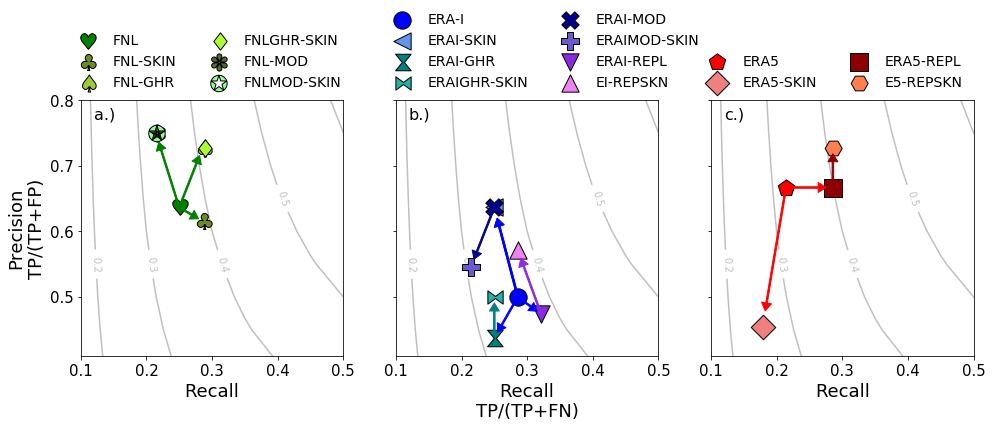

In [53]:
meth_oi = 'StaufferThompson2015'

rec_2d,prec_2d = np.meshgrid(np.arange(0,1.05,0.05),np.arange(0,1.05,0.05))

fig,ax = plt.subplots(figsize=(16,7),ncols=3,sharex=True,sharey=True)
for cc,case in enumerate(cases):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

    if 'ERA5' in case: 
        pltax = 2
        ncols = 2
    elif 'ERAI' in case:
        pltax = 1
        ncols = 4
    elif 'GFSR' in case:
        pltax = 0
        ncols = 3
    cm_case = case+'_d03'
    #marker_size = 90.0 + 360.0*(confusion_matrix_dict[cm_case][meth_oi]['F1']-marker_min)/(marker_max-marker_min)
    marker_size = 300.0
    if marker_size == 0.0:
        marker_style = 'x'
        marker_size = 20
    else:
        marker_style = 'o'
    ax[pltax].scatter(confusion_matrix_dict[cm_case][meth_oi]['recall'],confusion_matrix_dict[cm_case][meth_oi]['precision'],
                      marker=case_plt_dict['marker'], 
                      c=case_plt_dict['color'], edgecolor='k', # Colors
                      label=case_plt_dict['name'],
                      s=marker_size,zorder=5)
    
    
    if case in stn_pair_dict.keys():
        print(case,stn_pair_dict[case])
        arrow_xs = confusion_matrix_dict[stn_pair_dict[case]+'_d03'][meth_oi]['recall']
        arrow_ys = confusion_matrix_dict[stn_pair_dict[case]+'_d03'][meth_oi]['precision']
        arrow_xe = confusion_matrix_dict[case+'_d03'][meth_oi]['recall']
        arrow_ye = confusion_matrix_dict[case+'_d03'][meth_oi]['precision']
        
        arrow_lenx = 0.9*(arrow_xe - arrow_xs)
        arrow_leny = 0.9*(arrow_ye - arrow_ys)
                
        arrow_xe = arrow_xs + arrow_lenx
        arrow_ye = arrow_ys + arrow_leny
        
        #if case == 'GFSR_YSU_CHRN_MOD_NOSK_3DOM':
        #    connection_style = 'arc3,rad=-.1'
        #else:
        #    connection_style = None
        connection_style = None
        arrow = patches.FancyArrowPatch((arrow_xs,arrow_ys),(arrow_xe,arrow_ye),connectionstyle=connection_style,
                                        color=case_dict[stn_pair_dict[case]]['d0{}'.format(doms_of_interest[cc])]['color'],
                                        arrowstyle='Simple, tail_width=1.5, head_width=10, head_length=8',zorder=100)
        ax[pltax].add_patch(arrow)
        
for pltax in range(0,3):
    f1_lines = ax[pltax].contour(rec_2d,prec_2d,2.0*((prec_2d*rec_2d)/(prec_2d+rec_2d)),
                                 levels=np.arange(0.0,1,0.1),colors='k',alpha=0.25,zorder=0)
    f1_lbls = plt.clabel(f1_lines,fmt='%1.1f',inline=0)#,zorder=1)
    [txt.set_bbox(dict(boxstyle='square,pad=0.6',fc='w',ec='w',zorder=1)) for txt in f1_lbls]
    ax[pltax].set_xticks(np.arange(0,1,0.1))
    ax[pltax].set_yticks(np.arange(0,1,0.1))
    ax[pltax].set_ylim(0.41,0.8)
    ax[pltax].set_xlim(0.1,0.5)
    ax[pltax].set_aspect('equal')
    ax[pltax].legend(loc=(-0.05,1.02),frameon=False,fontsize=14,ncol=ncols)
    ax[pltax].tick_params(labelsize=15)
    if pltax == 1:
        ax[pltax].set_xlabel('Recall\nTP/(TP+FN)',size=18)
    else:
        ax[pltax].set_xlabel('Recall',size=18)

    ax[pltax].text(0.12,0.79,'{}.)'.format(ascii_lowercase[pltax]),ha='left',va='top',size=16)
ax[0].set_ylabel('Precision\nTP/(TP+FP)',size=18)

if save_figs:
    figname = '{}F1Score_{}'.format(save_dir,meth_oi)
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
plt.show()